## Evaluating Passes Assignemnt

The chief scout of your club wants to find good passers of the ball. He is interested in pass success rate, but realises also that the pure success rate isn't a reliable stat for his purposes. If players always take the safest option then they will never create.

What he really wants to find is players who are able to make difficult, but successful passes. To solve this problem start by creating a statistical model (logistic regression for example) that predicts pass success as a function of where on the pitch the pass is taken. In the first model use the only the start co-ordinates of the pass. to predict success. 

Improve your model as much as possible by including x^2 , y^2 , x*y, goal angle, end co-ordinates of the pass etc. You can also include whether the pass was a cross or another type of ball. 

When you feel you can't improve your model any more, then use it to rank players in the Wyscout free data. Which players are particularly good at making difficult passes?

**Submission should consist of 2 parts.**

1. A two page document containing: a non-technical description of how your method works
an explanation of the strengths and weaknesses of your approach.
choose one playing position (goalkeeper, full back, centre back, central midfielder, attacking midfielder or striker) and one of the leagues   
2. A runnable, commented code  as a (preferably) Python or R script that generates all the plots from the report and explains the method you have used. Important: this code should be a single file run immediately if placed with in the same directory as the Wyscout folder, which in turn contains Wyscout/events etc. i.e. exactly as is done in the expected goals tutorial. Do not use non-standard libraries and make sure there are no errors when run. 

This hand-in is graded on a mark 0-10. The total possible points for the course is 40. To pass with grade 3 requires 18 points, grade 4 requires 25 or higher, grade 5 is 32 or higher. This hand-in is also anonymously peer-reviewed, to help you improve, but the grade is decided by the teacher.



In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
import os

# stats packages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.calibration import calibration_curve

# pprint to make json easier to read
import pprint as pp

# plotting
from mplsoccer.pitch import Pitch

# to deal with the unicode characters of players names / team names in Wyscout
import codecs

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None


# Helper Functions

In [2]:
def show_event_breakdown(df_events, dic_tags):
    """
    Produces a full breakdown of the events, subevents, and the tags for the Wyscout dataset
    Use this to look at the various tags attributed to the event taxonomy
    """

    df_event_breakdown = df_events.groupby(['eventName','subEventName'])\
                        .agg({'id':'nunique','tags':lambda x: list(x)})\
                        .reset_index()\
                        .rename(columns={'id':'numSubEvents','tags':'tagList'})

    # creating a histogram of the tags per sub event
    df_event_breakdown['tagHist'] = df_event_breakdown.tagList.apply(lambda x: Counter([dic_tags[j] for i in x for j in i]))

    dic = {}

    for i, cols in df_event_breakdown.iterrows():
        eventName, subEventName, numEvents, tagList, tagHist = cols

        for key in tagHist:

            dic[f'{i}-{key}'] = [eventName, subEventName, numEvents, key, tagHist[key]]

    df_event_breakdown = pd.DataFrame.from_dict(dic, orient='index', columns=['eventName','subEventName','numSubEvents','tagKey','tagFrequency'])\
                                        .sort_values(['eventName','numSubEvents','tagFrequency'], ascending=[True, False, False])\
                                        .reset_index(drop=True)\

    return df_event_breakdown

In [3]:
def home_and_away(df):
    """
    Picks out the home and away teamIds and their scores
    """
    teamsData = df['teamsData']
    
    for team in teamsData:
        teamData = teamsData[team]
        if teamData.get('side') == 'home':
            homeTeamId = team
            homeScore = teamData.get('score')
            homeFormation = teamData.get('hasFormation')
        elif teamData.get('side') == 'away':
            awayTeamId = team
            awayScore = teamData.get('score')
            
    df['homeTeamId'], df['homeScore'] = homeTeamId, homeScore
    df['awayTeamId'], df['awayScore'] = awayTeamId, awayScore
    
    return df

In [4]:
def possession_indicator(df):
    """
    Function that identifies which team is in possession of the ball
    If the event is a found, interruption of offside, return a 0
    Winner of a duel is deemed in possession of the ball
    """
    
    # team identifiers
    teamId = df['teamId']
    homeTeamId = df['homeTeamId']
    awayTeamId = df['awayTeamId']
    teams = set([homeTeamId, awayTeamId])
    otherTeamId = list(teams - set([teamId]))[0]
    
    # eventName and subEventNames
    eventName = df['eventName']
    
    # success flag
    successFlag = df['successFlag']
    
    # assigning possession teamId
    if eventName in ['Pass','Free Kick','Others on the ball','Shot','Save attempt','Goalkeeper leaving line']:
        possessionTeamId = teamId
    elif eventName == 'Duel':
        possessionTeamId = teamId if successFlag == 1 else otherTeamId
    else:
        possessionTeamId = np.NaN
    
    return possessionTeamId


In [5]:
def strong_foot_flag(df):
    """
    Compare foot of pass with footedness of player
    Provides flag = 1 if pass played with strong foot of the player
    """
    tags = df['tags']
    foot = df['foot']
    
    # tags
    if 401 in tags:
        passFoot = 'L'
    elif 402 in tags:
        passFoot = 'R'
    elif 403 in tags:
        passFoot = 'H'
    else:
        passFoot = 'N'
        
    # feature
    if (passFoot == 'L') and (foot in ['L','B']):
        strongFlag = 1
    elif (passFoot == 'R') and (foot in ['R','B']):
        strongFlag = 1
    else:
        strongFlag = 0
    
    return strongFlag


def weak_foot_flag(df):
    """
    Compare foot of pass with footedness of player
    Provides flag = 1 if pass played with weak foot of the player
    """
    tags = df['tags']
    foot = df['foot']
    
    # tags
    if 401 in tags:
        passFoot = 'L'
    elif 402 in tags:
        passFoot = 'R'
    elif 403 in tags:
        passFoot = 'H'
    else:
        passFoot = 'N'
    
    # feature
    if (passFoot == 'L') and (foot == 'R'):
        weakFlag = 1
    elif (passFoot == 'R') and (foot == 'L'):
        weakFlag = 1
    else:
        weakFlag = 0
    
    return weakFlag

---

# Data Loader Functions

* Players
* Teams
* Tags
* Matches
* Formations
* Events

In [6]:
def get_players(player_file):
    """
    Returns dataframe of players
    """
    
    with open(player_file) as f:
        players_data = json.load(f)

    player_cols = ['playerId','shortName','foot','height','weight','birthDate','birthCountry','role','roleCode']

    df_players = pd.DataFrame([[i.get('wyId'),codecs.unicode_escape_decode(i.get('shortName'))[0],i.get('foot'),i.get('height'),i.get('weight'),i.get('birthDate')\
                              ,i.get('passportArea').get('name'),i.get('role').get('name'),i.get('role').get('code3')] for i in players_data], columns = player_cols)

    return df_players



def get_teams(team_file):
    """
    Returns dataframe of teams
    """
    
    with open(team_file) as f:
        teams_data = json.load(f)

    team_cols = ['teamId','teamName','officialTeamName','teamType','teamArea']

    df_teams = pd.DataFrame([[i.get('wyId'),codecs.unicode_escape_decode(i.get('name'))[0],codecs.unicode_escape_decode(i.get('officialName'))[0],i.get('type')\
                              ,i.get('area').get('name')] for i in teams_data], columns=team_cols)
    
    return df_teams



dic_tags = {
     101: 'Goal',
     102: 'Own goal',
     301: 'Assist',
     302: 'Key pass',
     1901: 'Counter attack',
     401: 'Left foot',
     402: 'Right foot',
     403: 'Head/body',
     1101: 'Direct',
     1102: 'Indirect',
     2001: 'Dangerous ball lost',
     2101: 'Blocked',
     801: 'High',
     802: 'Low',
     1401: 'Interception',
     1501: 'Clearance',
     201: 'Opportunity',
     1301: 'Feint',
     1302: 'Missed ball',
     501: 'Free space right',
     502: 'Free space left',
     503: 'Take on left',
     504: 'Take on right',
     1601: 'Sliding tackle',
     601: 'Anticipated',
     602: 'Anticipation',
     1701: 'Red card',
     1702: 'Yellow card',
     1703: 'Second yellow card',
     1201: 'Position: Goal low center',
     1202: 'Position: Goal low right',
     1203: 'Position: Goal center',
     1204: 'Position: Goal center left',
     1205: 'Position: Goal low left',
     1206: 'Position: Goal center right',
     1207: 'Position: Goal high center',
     1208: 'Position: Goal high left',
     1209: 'Position: Goal high right',
     1210: 'Position: Out low right',
     1211: 'Position: Out center left',
     1212: 'Position: Out low left',
     1213: 'Position: Out center right',
     1214: 'Position: Out high center',
     1215: 'Position: Out high left',
     1216: 'Position: Out high right',
     1217: 'Position: Post low right',
     1218: 'Position: Post center left',
     1219: 'Position: Post low left',
     1220: 'Position: Post center right',
     1221: 'Position: Post high center',
     1222: 'Position: Post high left',
     1223: 'Position: Post high right',
     901: 'Through',
     1001: 'Fairplay',
     701: 'Lost',
     702: 'Neutral',
     703: 'Won',
     1801: 'Accurate',
     1802: 'Not accurate'
}



def get_matches(match_repo):
    """
    Return dataframe of matches
    """
    
    match_files = os.listdir(match_repo)

    lst_df_matches = []

    # note, this does not include groupName
    match_cols = ["status","roundId","gameweek","teamsData","seasonId","dateutc","winner","venue"\
                  ,"wyId","label","date","referees","duration","competitionId","source"]

    for match_file in match_files:

        print (f'Processing {match_file}...')

        with open(f'matches/{match_file}') as f:
            data = json.load(f)
            df = pd.DataFrame(data)

            # adding some file source metadata
            df['source'] = match_file.replace('matches_','').replace('.json','')

            # dealing with the groupName column that's only in the international competitions
            df = df[match_cols]
            lst_df_matches.append(df)

    # concatenating match files
    df_matches = pd.concat(lst_df_matches, ignore_index=True)

    # applying home and away transformations using helper functions
    df_matches = df_matches.apply(home_and_away, axis=1)

    # and changing the wyId to matchId
    df_matches = df_matches.rename(columns={'wyId':'matchId'})

    # and filtering columns (may want to change this later)
    match_cols_final = ["source","competitionId","seasonId","roundId","gameweek","matchId","teamsData","dateutc","date"\
                        ,"homeTeamId","homeScore","awayTeamId","awayScore","duration","winner","venue","label"]

    df_matches = df_matches[match_cols_final]    
    
    return df_matches



def get_formations(df_matches):
    """
    Returns dataframe of formations within a match for all matches
    Adapted from https://github.com/CleKraus/soccer_analytics
    """

    lst_formations = list()
    
    for idx, match in df_matches.iterrows():

        matchId = match['matchId']

        # loop through the two teams
        for team in [0, 1]:
            team = match['teamsData'][list(match['teamsData'])[team]]
            teamId = team['teamId']

            # get all players that started on the bench
            player_bench = [player['playerId'] for player in team['formation']['bench']]
            df_bench = pd.DataFrame()
            df_bench['playerId'] = player_bench
            df_bench['lineup'] = 0

            # get all players that were in the lineup
            player_lineup = [
                player['playerId'] for player in team['formation']['lineup']
            ]
            df_lineup = pd.DataFrame()
            df_lineup['playerId'] = player_lineup
            df_lineup['lineup'] = 1

            # in case there were no substitutions in the match
            if team['formation']['substitutions'] == 'null':
                player_in = []
                player_out = []
                sub_minute = []
            # if there were substitutions
            else:
                player_in = [
                    sub['playerIn'] for sub in team['formation']['substitutions']
                ]
                player_out = [
                    sub['playerOut'] for sub in team['formation']['substitutions']
                ]
                sub_minute = [
                    sub['minute'] for sub in team['formation']['substitutions']
                ]

            # build a data frame who and when was substituted in
            df_player_in = pd.DataFrame()
            df_player_in['playerId'] = player_in
            df_player_in['substituteIn'] = sub_minute

            # build a data frame who and when was substituted out
            df_player_out = pd.DataFrame()
            df_player_out['playerId'] = player_out
            df_player_out['substituteOut'] = sub_minute

            # get the formation by concatenating lineup and bench players
            df_formation = pd.concat([df_lineup, df_bench], axis=0)
            df_formation['matchId'] = matchId
            df_formation['teamId'] = teamId

            # add information about substitutions
            df_formation = pd.merge(df_formation, df_player_in, how='left')
            df_formation = pd.merge(df_formation, df_player_out, how='left')

            lst_formations.append(df_formation)

    df_formations = pd.concat(lst_formations)

    # get the minute the player started and the minute the player ended the match
    df_formations['minuteStart'] = np.where(
        df_formations['substituteIn'].isnull(), 0, df_formations['substituteIn']
    )
    df_formations['minuteEnd'] = np.where(
        df_formations['substituteOut'].isnull(), 90, df_formations['substituteOut']
    )

    # make sure the match always lasts 90 minutes
    df_formations['minuteStart'] = np.minimum(df_formations['minuteStart'], 90)
    df_formations['minuteEnd'] = np.minimum(df_formations['minuteEnd'], 90)

    # set minuteEnd to 0 in case the player was not in the lineup and did not get substituted in
    df_formations['minuteEnd'] = np.where(
        (df_formations['lineup'] == 0) & (df_formations['substituteIn'].isnull()),
        0,
        df_formations['minuteEnd'],
    )

    # compute the minutes played
    df_formations['minutesPlayed'] = (
        df_formations['minuteEnd'] - df_formations['minuteStart']
    )

    # use a binary flag of substitution rather than a minute and NaNs
    df_formations['substituteIn'] = 1 * (df_formations['substituteIn'].notnull())
    df_formations['substituteOut'] = 1 * (df_formations['substituteOut'].notnull())

    return df_formations



def get_events(event_repo, leagueSelectionFlag = 0, leagueSelection = 'England'):
    """
    Returns dataframe of events
    """
    
    events_files = os.listdir(event_repo)
    
    lst_df_events = []

    if leagueSelectionFlag == 1:
        events_files = [i for i in events_files if i == f'events_{leagueSelection}.json']

    event_cols = ['source','matchId','matchPeriod','eventSec','teamId','id','eventId','eventName','subEventId','subEventName','playerId','positions','tags']

    for events_file in events_files:

        print (f'Processing {events_file}...')

        with open(f'events/{events_file}') as f:
            data = json.load(f)
            df = pd.DataFrame(data)
            df['source'] = events_file.replace('events_','').replace('.json','')        
            lst_df_events.append(df)

    df_events = pd.concat(lst_df_events, ignore_index=True)

    # applying column re-ordering
    df_events = df_events[event_cols]
   
    return df_events

---

# Event Feature Engineering Function

* Rejigs tags
* Applies `homeFlag`
* Applies event `successFlag`
* Applies `matchEventIndex` (an ordering of every event that occurs within a match from 1-n)
* Applies `possessionTeamId` (the teamId that's in possession of the ball)
* Applies `possessionSequenceIndex`
* Applies `goalDelta` (the game state)
* Applies `numReds` (the cumulative number of red cards a team has accrued throughout a match)
* Applies `weakFlag` and `strongFlag` (for footedness of player and foot used for pass)
* Unpacks `positions`
* Applies `possessionStartSec`
* Applies `playerPossessionTimeSec`
* Re-orders and filters `df_events`

In [7]:
def event_feature_engineering(df_events):
    """
    Takes in raw df_events dataframe and returns an augmented df_events dataframe with features for xPass model feature engineering
    """
    
    # Re-jigging tags -> list of integers
    print ('Rejigging tags...')
    df_events['tags'] = df_events.tags.apply(lambda x: [i.get('id') for i in x])
    
    
    # Applies homeFlag by 1) first merging on df_matches and then 2) applying helper function
    print ('Applying homeFlag...')
    ## 1)
    df_events = df_events.merge(df_matches, on=['matchId','source'], how = 'inner')
    ## 2)
    df_events['homeFlag'] = df_events.apply(lambda x: 1 if int(x.teamId) == int(x.homeTeamId) else 0, axis=1)
    
    
    # Applying success flag
    print ('Applying successFlag...')
    df_events['successFlag'] = df_events.tags.apply(lambda x: 1 if 1801 in x else 0)
    
    
    # 1) Ordering of events so that they're in precisely chronological order, and then 2) resorting (as the merge with df_matches will cause df_events to become unsorted)
    print ('Applying matchEventIndex...')
    ## 1)
    df_events['matchEventIndex'] = df_events.sort_values(['matchId','matchPeriod','eventSec'], ascending=[True, True, True])\
                                        .groupby('matchId')\
                                        .cumcount() + 1
    ## 2)
    df_events = df_events.sort_values(['matchId','matchEventIndex'], ascending=[True,True])
    
    
    # 1) Applying possession team indicator and then 2) forward filling the NaNs with the existing team (until possession is explicitly transferred)
    print ('Applying possessionTeamId...')
    ## 1)
    df_events['possessionTeamId'] = df_events.apply(possession_indicator, axis=1)
    ## 2) Filling the nans
    df_events['possessionTeamId'] = df_events.possessionTeamId.fillna(method='ffill')
    
    
    # Sequencing the possessions (each possession  will have it's own index per match)
    print ('Applying possessionSequenceIndex...')
    ## 1) initiate sequence at 0
    df_events['possessionSequenceIndex'] = 0
    ## 2) every time there's a change in sequence, you set a value of 1
    df_events['possessionSequenceIndex'][((df_events['possessionTeamId'] != df_events['possessionTeamId'].shift(1))) \
                                         | ((df_events['matchPeriod'] != df_events['matchPeriod'].shift(1)))] = 1
    ## 3) take a cumulative sum of the 1s per match
    df_events['possessionSequenceIndex'] = df_events.groupby('matchId')['possessionSequenceIndex'].cumsum()
    
    
    # Applying Game State
    ## Note this method is only 95% accurate; suspect that's sufficiently fine for this feature for this application
    print ('Applying gameState...')
    ## 1) getting goals scored flag
    df_events['goalScoredFlag'] = df_events.apply(lambda x: 1 if 101 in x.tags and x.eventName in ['Shot','Free Kick'] else 0, axis=1)
    ## 2) getting goal conceded flag
    df_events['goalsConcededFlag'] = df_events.apply(lambda x: 1 if 101 in x.tags and x.eventName == 'Save attempt' else 0, axis=1)
    ## 3) Cumulatively summing the goals scored
    df_events['goalsScored'] = df_events.sort_values(['matchId','matchPeriod','eventSec'], ascending=[True, True, True])\
                                        .groupby(['matchId','teamId'])\
                                        ['goalScoredFlag'].cumsum()
    ## 4) Cumulatively summing the goals conceded
    df_events['goalsConceded'] = df_events.sort_values(['matchId','matchPeriod','eventSec'], ascending=[True, True, True])\
                                        .groupby(['matchId','teamId'])\
                                        ['goalsConcededFlag'].cumsum()
    ## 5) Calculating the goal delta
    df_events['goalDelta'] = df_events['goalsScored'] - df_events['goalsConceded']
    
    
    # Applying red cards to calculate the difference in the number of players on each team
    print ('Applying numReds...')
    ## 1) Applying red card flag
    df_events['redCardFlag'] = df_events.tags.apply(lambda x: -1 if 1701 in x else 0)
    
    ## 2) Applying Excess Player flag to the other team
    df_reds = df_events.loc[df_events['redCardFlag'] == -1, ['matchId','teamId','matchEventIndex','id']]

    lst_redOtherTeamFlag = []

    for idx, cols in df_reds.iterrows():
        matchId, teamId, matchEventIndex, Id = cols
        try:
            redOtherTeamId = df_events.loc[(df_events['matchId'] == matchId) & (df_events['teamId'] != teamId) & (df_events['matchEventIndex'] > matchEventIndex)].sort_values('matchEventIndex', ascending=True)['id'].values[0]
            lst_redOtherTeamFlag.append(redOtherTeamId)
        except:
            continue

    df_events.loc[df_events['id'].isin(lst_redOtherTeamFlag), 'redCardFlag'] = 1
    
    ## 3) Cumulatively summing the number of red cards on a team throughout a game
    df_events['numReds'] = df_events.sort_values(['matchId','matchPeriod','eventSec'], ascending=[True, True, True])\
                                    .groupby(['matchId','teamId'])\
                                    ['redCardFlag'].cumsum()
    
    
    # Applying strong and weak foot flags
    print ('Applying weakFlag and strongFlag for footedness...')
    ## 1) adding player metadata
    df_events = df_events.merge(df_players, on='playerId', how='inner')
    ## 2) Cleaning up the foot preference flags of the players
    df_events['foot'] = df_events.foot.apply(lambda x: 'L' if x == 'left' else 'R' if x == 'right' else 'B' if x == 'both' else 'N')
    ## 3) Applying weak foot flag (mainly impacts crosses)
    df_events['weakFlag'] = df_events.apply(weak_foot_flag, axis=1)
    ## 4) Applying strong foot flag (this isn't seen as significant in the logistic regression, but keeping it in for completeness)
    df_events['strongFlag'] = df_events.apply(strong_foot_flag, axis=1)
    
    
    # Unpacking positions: Found that this multi-lambda method is by far and away the quickest rather than a multi-stage apply when dealing with 3M events
    print ('Unpacking positions...')
    # (this takes about a minute for the full Wyscout dataset which is pretty good)
    ## 1) counting the number of positions found in the position dic
    df_events['numPositions'] = df_events.positions.apply(lambda x: len(x))
    ## 2) Getting the starting x,y
    df_events['startPositions'] = df_events.positions.apply(lambda x: x[0])
    df_events['start_x'] = df_events.startPositions.apply(lambda x: x.get('x'))
    df_events['start_y'] = df_events.startPositions.apply(lambda x: x.get('y'))
    ## 3) Getting the ending x,y
    df_events['endPositions'] = df_events.apply(lambda x: x.positions[1] if x.numPositions == 2 else {}, axis=1)
    df_events['end_x'] = df_events.endPositions.apply(lambda x: x.get('x', None))
    df_events['end_y'] = df_events.endPositions.apply(lambda x: x.get('y', None))
    
    
    # Getting the time that the team has been in possession until the pass has been made (1) takes a while, but allows 2) to be vectorised)
    print ('Applying possessionStartSec...')
    ## 1) getting the time since the possession started
    df_events['possessionStartSec'] = df_events.loc[df_events.groupby(['matchId','possessionSequenceIndex'])['eventSec'].transform('idxmin'), 'eventSec'].values
    ## 2) calculating the time of the posession
    df_events['possessionTimeSec'] = df_events['eventSec'] - df_events['possessionStartSec']
    
    
    # Getting the time that the player has been in possession
    print ('Applying playerPossessionTimeSec...')
    ## 1) initialising at 0
    df_events['playerPossessionTimeSec'] = 0
    ## 2) checks that the previous event was part of the same possession sequence within the same match, and if it is, calculates possession time in seconds
    df_events['playerPossessionTimeSec'][((df_events['matchId'] == df_events['matchId'].shift(1)) &\
                                         (df_events['possessionSequenceIndex'] == df_events['possessionSequenceIndex'].shift(1)))]\
                                        = df_events['eventSec'] - df_events['eventSec'].shift(1)
    
    
    # Getting previous event
    print ('Grabbing previous event...')
    df_events['previousSubEventName'] = 'Match Start'
    df_events['previousSubEventName'][df_events['matchId'] == df_events['matchId'].shift(1)] = df_events['subEventName'].shift(1)

    
    # finally, tidying  up  columns
    df_events = df_events[['source','matchId','matchPeriod','eventSec','possessionTimeSec','playerPossessionTimeSec','matchEventIndex','teamId','homeTeamId','homeScore','awayTeamId','awayScore','homeFlag','id'\
                           ,'eventName','subEventName','previousSubEventName','possessionTeamId','possessionSequenceIndex','playerId','shortName','roleCode','strongFlag','weakFlag','goalDelta','numReds'\
                           ,'start_x','start_y','end_x','end_y','tags','successFlag']].sort_values(['matchId','matchEventIndex'], ascending=[True,True])
    
    print ('Outputting df_events.')
    return df_events

In [8]:
def pass_feature_engineering(df_events, pitchLength = 105, pitchWidth = 68, outputToCsvFlag = 0):
    """
    Highly vectorised set of transformations
    
    Takes in the feature enriched df_events
    Filters on the different pass types
    Applies pass specific features
    Outputs df_passes
    """
    
    dic_passes = {
        'Simple pass':['Pass','Simple pass'],
        'High pass':['Pass','High pass'],
        'Head pass':['Pass','Head pass'],
        'Cross':['Pass','Cross'],
        'Launch':['Pass','Launch'],
        'Smart pass':['Pass','Smart pass'],
        'Hand pass':['Pass','Hand pass'],
        'Free kick cross':['Free Kick','Free kick cross'],
        'Corner':['Free Kick','Corner'],
        'Free Kick':['Free Kick','Free Kick'],
        'Throw in':['Free Kick','Throw in']
    }
    
    
    # Filtering df_events on relevant pass events
    ## 1) Applying filter
    print ('Applying pass filter...')
    df_passes = df_events.loc[df_events['subEventName'].isin(list(dic_passes.keys()))].copy()
    ## 2) DQ step: getting rid of two passes that don't have and end co-ord
    df_passes = df_passes.loc[pd.isna(df_passes['end_x']) == False].copy()
    
    
    # Series of geometric transformations
    print ('Applying geometric transformations...')
    ## 1) splitting the pitch into thirds and capturing the transition between thirds
    df_passes['startThird'] = df_passes.start_x.apply(lambda x: 1 if x < 34 else 2 if x < 67 else 3)
    df_passes['endThird'] = df_passes.end_x.apply(lambda x: 1 if x < 34 else 2 if x < 67 else 3)
    df_passes['thirdTransitionDelta'] = df_passes['endThird'] - df_passes['startThird']
    
    ## 2) transforming pitch dimensions from 100x100 grid to dimensions in meters
    df_passes['startPassM_x'] = df_passes.start_x*pitchLength/100
    df_passes['startPassM_y'] = df_passes.start_y*pitchWidth/100
    df_passes['endPassM_x'] = df_passes.end_x*pitchLength/100
    df_passes['endPassM_y'] = df_passes.end_y*pitchWidth/100

    ## 3) getting the squares of the x's
    df_passes['startPassM_xSquared'] = df_passes['startPassM_x']**2
    df_passes['endPassM_xSquared'] = df_passes['endPassM_x']**2

    ## 4) getting some central y stats and squared stats (same definitions as in David's code)
    df_passes['start_c'] = abs(df_passes['start_y'] - 50)
    df_passes['end_c'] = abs(df_passes['end_y'] - 50)
    df_passes['startM_c'] = df_passes['start_c']*pitchWidth/100
    df_passes['endM_c'] = df_passes['end_c']*pitchWidth/100
    df_passes['start_cSquared'] = df_passes['start_c']**2
    df_passes['end_cSquared'] = df_passes['end_c']**2
    df_passes['startM_cSquared'] = df_passes['startM_c']**2
    df_passes['endM_cSquared'] = df_passes['endM_c']**2

    ## 5) getting distance to ball
    df_passes['vec_x'] = df_passes['endPassM_x'] - df_passes['startPassM_x']
    df_passes['vec_y'] = df_passes['endPassM_y'] - df_passes['startPassM_y']
    df_passes['D'] = np.sqrt(df_passes['vec_x']**2 + df_passes['vec_y']**2)
    df_passes['Dsquared'] = df_passes.D**2
    df_passes['Dcubed'] = df_passes.D**3

    ## 6) DQ step: getting rid of events where the vec_x = vec_y = 0 (look like data errors)
    df_passes = df_passes.loc[~((df_passes['vec_x'] == 0) & (df_passes['vec_y'] == 0))].copy()

    ## 7) calculating passing angle in radians
    df_passes['a'] = np.arctan(df_passes['vec_x'] / abs(df_passes['vec_y']))
    #df_passes['aNew'] = np.arctan(df_passes['vec_x'] / (df_passes['endM_c'] - df_passes['startM_c']))
    
    ## 8) calculating shooting angle from initial position
    df_passes['aShooting'] = np.arctan(7.32 * df_passes['startPassM_x'] / (df_passes['startPassM_x']**2 + df_passes['startM_c']**2 - (7.32/2)**2))
    df_passes['aShooting'] = df_passes.aShooting.apply(lambda x: x+np.pi if x<0 else x)
    
    ## 9) calculating shooting angle from final position (i.e. )
    df_passes['aShootingFinal'] = np.arctan(7.32 * df_passes['endPassM_x'] / (df_passes['endPassM_x']**2 + df_passes['endM_c']**2 - (7.32/2)**2))
    df_passes['aShootingFinal'] = df_passes.aShootingFinal.apply(lambda x: x+np.pi if x<0 else x)
    
    ## 10) change in shooting angle caused by the pass
    df_passes['aShootingChange'] = df_passes['aShootingFinal'] - df_passes['aShooting']
    
    ## 11) distance to goal
    df_passes['DGoalStart'] = np.sqrt((pitchLength - df_passes['startPassM_x'])**2 + df_passes['startM_c']**2)
    df_passes['DGoalEnd'] = np.sqrt((pitchLength - df_passes['endPassM_x'])**2 + df_passes['endM_c']**2)
    df_passes['DGoalChange'] = df_passes['DGoalEnd'] - df_passes['DGoalStart']
    
    ## final) re-ordering cols
    df_passes = df_passes.sort_values(['matchId','matchEventIndex'], ascending=[True,True])
    
    
    
    # Within each possession sequence, applies the pass index (so the first pass in a possession is 1, and the second is 2, etc.)
    print ('Applying passIndexWithinSequence...')
    ## 1) produces index
    df_passes['passIndexWithinSequence'] = df_passes.sort_values(['matchId','possessionSequenceIndex','matchEventIndex'])\
                                                    .groupby(['matchId','possessionSequenceIndex'])\
                                                    .cumcount() + 1
    ## 2) LOOKAHEAD BIAS: WILL NOT INCLUDE THIS IN FINAL MODEL
    ## Calculating mean number of passes per possession per team
    df_meanNumPasses =  pd.DataFrame(df_passes.groupby(['teamId','possessionSequenceIndex'])\
                             .agg({'passIndexWithinSequence':np.mean})\
                             .groupby('teamId')\
                             .passIndexWithinSequence.mean())\
                            .reset_index()\
                            .rename(columns={'passIndexWithinSequence':'meanNumPassesPerSequence'})
    ## 3) Re-introducing this mean number of passes per possession via a join
    df_passes = df_passes.merge(df_meanNumPasses, how='inner', on='teamId')
    ## 4) getting the over under for the number of passes for that team
    ## COULD POTENTIALLY USE THIS IF HAD MULTIPLE YEARS OF HISTORY, AS IT SHOWS A CHARACTERISTIC OF A TEAM
    df_passes['numPassOverUnder'] = df_passes['passIndexWithinSequence'] - df_passes['meanNumPassesPerSequence']
    
    
    
    # Final set of flags (some are post-hoc so can't be used in the regression, but just adding for completeness)
    print ('Applying final set of flags...')
    ## 1) applying interception flag - this is of course highly correlated to an unsuccessful outcome, so won't be part of the regression
    df_passes['interceptionFlag'] = df_passes.tags.apply(lambda x: 1 if 1401 in x else 0)
    ## 2) applying dangerousBallLostFlag - this will also NOT be part of the regression
    df_passes['dangerousBallLostFlag'] = df_passes.tags.apply(lambda x: 1 if 2001 in x else 0)
    ## 3) counter attack flag
    df_passes['counterAttackFlag'] = df_passes.tags.apply(lambda x: 1 if 1901 in x else 0)
    ## 4) assist flag
    df_passes['assistFlag'] = df_passes.tags.apply(lambda x: 1 if 301 in x else 0)
    
    
    if outputToCsvFlag == 1:
        print ('Outputting df_passes to CSV...')
        df_passes.to_csv('df_passes.csv', index=None)
    
    print ('Outputting df_passes.')
    return df_passes


---

# Model Application: Applying Four Models to Produce **xP** Variations to **Test** Data

In [9]:
# applying basic, added, and advanced models to test data
def apply_xP_model_to_test(models):
    """
    Applying the four different models to produce four xP values
    """
    basic, added, adv_canonical, adv_probit = models
    
    print ('Applying models...')
    df_passes_test['xP_basic'] = basic.predict(df_passes_test)
    df_passes_test['xP_added'] = added.predict(df_passes_test)
    df_passes_test['xP_logit'] = adv_canonical.predict(df_passes_test)
    df_passes_test['xP'] = adv_probit.predict(df_passes_test)
    print (f'Done applying {len(models)} models.')
    
    return df_passes_test

---

# Model Validation: Calibration Curves

In [10]:
def plot_calibration_curve(df_passes_test, show_advanced=1, save_output=0):

    fig = plt.figure(figsize=(10, 10))

    # Plotting perfect calibration (line y=x)
    plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated Model')

    alpha = 0.6
    numBins = 25

    # FOUR calibration curves - Tricky to plot all four at a time, so just do a Simple Vs Advanced
    if show_advanced == 0:
        ## 1) Simple Model
        fraction_of_positives, mean_predicted_value = calibration_curve(df_passes_test.successFlag, df_passes_test.xP_basic, n_bins=numBins)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Basic Model', alpha = alpha, color='red')

        ## 2) Added Model
        fraction_of_positives, mean_predicted_value = calibration_curve(df_passes_test.successFlag, df_passes_test.xP_added, n_bins=numBins)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Added Features', alpha = alpha, color='blue')

    elif show_advanced == 1:
        ## 3) Advanced Model: Canonical (Logit) Link function
        fraction_of_positives, mean_predicted_value = calibration_curve(df_passes_test.successFlag, df_passes_test.xP_logit, n_bins=numBins)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Advanced Features: Logit Link', alpha = alpha, color='black')

        ## 4) Advanced Model: Probit Link function
        fraction_of_positives, mean_predicted_value = calibration_curve(df_passes_test.successFlag, df_passes_test.xP, n_bins=numBins)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Advanced Features: Probit Link', alpha = alpha, color='orange')

    plt.ylabel('Fraction of Successful Passes', fontsize=18)
    plt.xlabel('Mean xP', fontsize=18)

    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])

    plt.legend(loc="lower right", fontsize=18)
    #plt.title('Calibration Plot', fontsize=24)

    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    plt.tight_layout()
    
    if save_output == 1:
        plt.savefig(f'calibration_{show_advanced}.pdf', dpi=300, format='pdf', bbox_inches='tight')
    
    return plt.show()

---

# Model Validation: Metric Scores

* Brier Score
* Precision, Recall, F1
* AUC
* Accuracy

In [11]:
def calculate_model_metrics(df_passes_test, xPtype='xP', log_reg_decision_threshold = 0.65):
    '''
    Applies Logistic Regression Decision Threshold (i.e. applying the model to attribute whether a pass would or would have not been successful)
    And calculates a bunch of related metrics
    '''
    
    df_passes_test['predictedSuccess'] = df_passes_test[xPtype].apply(lambda x: 1 if x > log_reg_decision_threshold else 0)

    brierScore = metrics.brier_score_loss(df_passes_test.successFlag, df_passes_test[xPtype])

    # precision = TRUE POSITIVE / (TRUE POSITIVE + FALSE POSITIVE)
    # ratio of correctly positive observations / all predicted positive observations
    precisionScore = metrics.precision_score(df_passes_test.successFlag, df_passes_test.predictedSuccess)

    # recall = TRUE POSITIVE / (TRUE POSITIVE + FALSE NEGATIVE)
    # ratio of correctly positive observations / all true positive observations (that were either correctly picked TP or missed FN)
    recallScore = metrics.recall_score(df_passes_test.successFlag, df_passes_test.predictedSuccess)

    # weighted average of precision and recall
    f1Score = metrics.f1_score(df_passes_test.successFlag, df_passes_test.predictedSuccess)

    AUCScore = metrics.roc_auc_score(df_passes_test.successFlag, df_passes_test.predictedSuccess)

    # overall accuracy score: ratio of all correct over count of all observations
    accuracyScore = metrics.accuracy_score(df_passes_test.successFlag, df_passes_test.predictedSuccess)

    return print (f'Brier Score: {brierScore}\n\nPrecision Score: {precisionScore}\n\nRecall Score: {recallScore}\n\nF1 Score: {f1Score}\n\nAUC Score: {AUCScore}\n\nAccuracyScore: {accuracyScore}')

---

**CODE STARTS HERE**

---


&nbsp;

&nbsp;

&nbsp;

# 1) Loading Data

### Loading Players, Teams, Matches, Formations, Events

In [12]:
%%time

df_players = get_players('players.json')
df_teams = get_teams('teams.json')
df_matches = get_matches('matches')
df_formations = get_formations(df_matches)
df_events = get_events('events', leagueSelectionFlag = 0, leagueSelection = 'England')

print ('Done')

Processing matches_World_Cup.json...
Processing matches_Italy.json...
Processing matches_Germany.json...
Processing matches_England.json...
Processing matches_France.json...
Processing matches_Spain.json...
Processing matches_European_Championship.json...
Processing events_France.json...
Processing events_Spain.json...
Processing events_Germany.json...
Processing events_European_Championship.json...
Processing events_World_Cup.json...
Processing events_Italy.json...
Processing events_England.json...
Done
CPU times: user 1min 30s, sys: 5.18 s, total: 1min 36s
Wall time: 1min 37s


---

# 2) Event Feature Engineering

**Longest part of data preparation due to all of the nested feature extraction from the events data**:

> Takes about 3 minutes if a single league is selected (`leagueSelectionFlag = 1` above).

> Takes about 10 minutes if all leagues and international competitions are thrown into the mix.

In [13]:
%%time

df_events = event_feature_engineering(df_events)
df_events.head()

Rejigging tags...
Applying homeFlag...
Applying successFlag...
Applying matchEventIndex...
Applying possessionTeamId...
Applying possessionSequenceIndex...
Applying gameState...
Applying numReds...
Applying weakFlag and strongFlag for footedness...
Unpacking positions...
Applying possessionStartSec...
Applying playerPossessionTimeSec...
Grabbing previous event...
Outputting df_events.
CPU times: user 9min 45s, sys: 44.4 s, total: 10min 29s
Wall time: 10min 43s


,source,matchId,matchPeriod,eventSec,possessionTimeSec,playerPossessionTimeSec,matchEventIndex,teamId,homeTeamId,homeScore,awayTeamId,awayScore,homeFlag,id,eventName,subEventName,previousSubEventName,possessionTeamId,possessionSequenceIndex,playerId,shortName,roleCode,strongFlag,weakFlag,goalDelta,numReds,start_x,start_y,end_x,end_y,tags,successFlag
0,European_Championship,1694390,1H,1.255990,0.000000,0.0,1,4418,4418,2,11944,1,1,88178642,Pass,Simple pass,Match Start,4418,1,26010,O. Giroud,FWD,0,0,0,0,50,48,47.0,50.0,[1801],1
1388,European_Championship,1694390,1H,2.351908,1.095918,0.0,2,4418,4418,2,11944,1,1,88178643,Pass,Simple pass,Match Start,4418,1,3682,A. Griezmann,FWD,0,0,0,0,47,50,41.0,48.0,[1801],1
3995,European_Championship,1694390,1H,3.241028,1.985038,0.0,3,4418,4418,2,11944,1,1,88178644,Pass,Simple pass,Match Start,4418,1,31528,N. Kanté,MID,0,0,0,0,41,48,32.0,35.0,[1801],1
7938,European_Championship,1694390,1H,6.033681,4.777691,0.0,4,4418,4418,2,11944,1,1,88178645,Pass,High pass,Match Start,4418,1,7855,L. Koscielny,DEF,0,0,0,0,32,35,89.0,6.0,[1802],0
10780,European_Championship,1694390,1H,13.143591,11.887601,0.0,5,4418,4418,2,11944,1,1,88178646,Duel,Ground defending duel,Match Start,4418,1,25437,B. Matuidi,MID,0,0,0,0,89,6,85.0,0.0,"[702, 1801]",1


### For some bizarre reason, this code doesn't work if contained within the event feature engineering function, so adding it on here.

(Doesn't effect modelling, only plotting.)

In [14]:
# Getting the recipient player of an action (need to do this pre-pass filter as the next action may well not be a pass, and it'd be 
## highly suboptimal to clip dangerous passes that resulted in shots and goals)
print ('Applying recipient of an event...')
possessionEventNames = ['Pass','Others on the ball','Shot']

df_events['passRecipientPlayerIdNext1'] = None
df_events['passRecipientPlayerIdNext2'] = None
df_events['passRecipientPlayerIdNext3'] = None
df_events['passRecipientPlayerIdNext4'] = None

df_events['passRecipientPlayerIdNext1'][((df_events['matchId'] == df_events['matchId'].shift(-1)) &\
                                    (df_events['matchEventIndex'] == (df_events['matchEventIndex'].shift(-1) - 1)) &\
                                    (df_events['possessionSequenceIndex'] == df_events['possessionSequenceIndex'].shift(-1)) &\
                                    (df_events['eventName'].shift(-1).isin(possessionEventNames)) &\
                                    (df_events['end_x'] == df_events['start_x'].shift(-1)) &\
                                    (df_events['end_y'] == df_events['start_y'].shift(-1)) &\
                                    (df_events['successFlag'] == 1))]\
                                        = df_events['playerId'].shift(-1)

df_events['passRecipientPlayerIdNext2'][((df_events['matchId'] == df_events['matchId'].shift(-2)) &\
                                    (df_events['matchEventIndex'] == (df_events['matchEventIndex'].shift(-2) - 2)) &\
                                    (df_events['possessionSequenceIndex'] == df_events['possessionSequenceIndex'].shift(-2)) &\
                                    (df_events['eventName'].shift(-2).isin(possessionEventNames)) &\
                                    (df_events['end_x'] == df_events['start_x'].shift(-2)) &\
                                    (df_events['end_y'] == df_events['start_y'].shift(-2)) &\
                                    (df_events['successFlag'] == 1))]\
                                        = df_events['playerId'].shift(-2)

df_events['passRecipientPlayerIdNext3'][((df_events['matchId'] == df_events['matchId'].shift(-3)) &\
                                    (df_events['matchEventIndex'] == (df_events['matchEventIndex'].shift(-3) - 3)) &\
                                    (df_events['possessionSequenceIndex'] == df_events['possessionSequenceIndex'].shift(-3)) &\
                                    (df_events['eventName'].shift(-3).isin(possessionEventNames)) &\
                                    (df_events['end_x'] == df_events['start_x'].shift(-3)) &\
                                    (df_events['end_y'] == df_events['start_y'].shift(-3)) &\
                                    (df_events['successFlag'] == 1))]\
                                        = df_events['playerId'].shift(-3)

df_events['passRecipientPlayerIdNext4'][((df_events['matchId'] == df_events['matchId'].shift(-4)) &\
                                    (df_events['matchEventIndex'] == (df_events['matchEventIndex'].shift(-4) - 4)) &\
                                    (df_events['possessionSequenceIndex'] == df_events['possessionSequenceIndex'].shift(-4)) &\
                                    (df_events['eventName'].shift(-4).isin(possessionEventNames)) &\
                                    (df_events['end_x'] == df_events['start_x'].shift(-4)) &\
                                    (df_events['end_y'] == df_events['start_y'].shift(-4)) &\
                                    (df_events['successFlag'] == 1))]\
                                        = df_events['playerId'].shift(-4)


df_events['passRecipientPlayerId'] = df_events.apply(lambda x: int(x.passRecipientPlayerIdNext1) if x.passRecipientPlayerIdNext1 != None else\
                                                    int(x.passRecipientPlayerIdNext2) if x.passRecipientPlayerIdNext2 != None else\
                                                    int(x.passRecipientPlayerIdNext3) if x.passRecipientPlayerIdNext3 != None else\
                                                    int(x.passRecipientPlayerIdNext4) if x.passRecipientPlayerIdNext4 != None else None, axis=1) 


Applying recipient of an event...


---

# 3) Pass Specific Feature Engineering

**Highly vectorised, so only takes a minute with all leagues loaded in**


In [15]:
%%time

df_passes = pass_feature_engineering(df_events, outputToCsvFlag=0)
df_passes.head()

Applying pass filter...
Applying geometric transformations...
Applying passIndexWithinSequence...
Applying final set of flags...
Outputting df_passes.
CPU times: user 23.1 s, sys: 7.62 s, total: 30.7 s
Wall time: 31.5 s


,source,matchId,matchPeriod,eventSec,possessionTimeSec,playerPossessionTimeSec,matchEventIndex,teamId,homeTeamId,homeScore,awayTeamId,awayScore,homeFlag,id,eventName,subEventName,previousSubEventName,possessionTeamId,possessionSequenceIndex,playerId,shortName,roleCode,strongFlag,weakFlag,goalDelta,numReds,start_x,start_y,end_x,end_y,tags,successFlag,passRecipientPlayerIdNext1,passRecipientPlayerIdNext2,passRecipientPlayerIdNext3,passRecipientPlayerIdNext4,passRecipientPlayerId,startThird,endThird,thirdTransitionDelta,startPassM_x,startPassM_y,endPassM_x,endPassM_y,startPassM_xSquared,endPassM_xSquared,start_c,end_c,startM_c,endM_c,start_cSquared,end_cSquared,startM_cSquared,endM_cSquared,vec_x,vec_y,D,Dsquared,Dcubed,a,aShooting,aShootingFinal,aShootingChange,DGoalStart,DGoalEnd,DGoalChange,passIndexWithinSequence,meanNumPassesPerSequence,numPassOverUnder,interceptionFlag,dangerousBallLostFlag,counterAttackFlag,assistFlag
0,European_Championship,1694390,1H,1.255990,0.000000,0.0,1,4418,4418,2,11944,1,1,88178642,Pass,Simple pass,Match Start,4418,1,26010,O. Giroud,FWD,0,0,0,0,50,48,47.0,50.0,[1801],1,3682,None,None,None,3682.0,2,2,0,52.50,32.64,49.35,34.00,2756.2500,2435.4225,2,0.0,1.36,0.00,4,0.0,1.8496,0.0000,-3.15,1.36,3.431049,11.7721,40.390657,-1.163226,0.139111,0.148057,0.008946,52.517612,55.650000,3.132388,1,2.699072,-1.699072,0,0,0,0
1,European_Championship,1694390,1H,2.351908,1.095918,0.0,2,4418,4418,2,11944,1,1,88178643,Pass,Simple pass,Match Start,4418,1,3682,A. Griezmann,FWD,0,0,0,0,47,50,41.0,48.0,[1801],1,31528,None,None,None,31528.0,2,2,0,49.35,34.00,43.05,32.64,2435.4225,1853.3025,0,2.0,0.00,1.36,0,4.0,0.0000,1.8496,-6.30,-1.36,6.445122,41.5396,267.727798,-1.358186,0.148057,0.169460,0.021403,55.650000,61.964926,6.314926,2,2.699072,-0.699072,0,0,0,0
2,European_Championship,1694390,1H,3.241028,1.985038,0.0,3,4418,4418,2,11944,1,1,88178644,Pass,Simple pass,Match Start,4418,1,31528,N. Kanté,MID,0,0,0,0,41,48,32.0,35.0,[1801],1,7855,None,None,None,7855.0,2,1,-1,43.05,32.64,33.60,23.80,1853.3025,1128.9600,2,15.0,1.36,10.20,4,225.0,1.8496,104.0400,-9.45,-8.84,12.940174,167.4481,2166.807530,-0.818737,0.169460,0.198996,0.029537,61.964926,72.124892,10.159965,3,2.699072,0.300928,0,0,0,0
3,European_Championship,1694390,1H,6.033681,4.777691,0.0,4,4418,4418,2,11944,1,1,88178645,Pass,High pass,Match Start,4418,1,7855,L. Koscielny,DEF,0,0,0,0,32,35,89.0,6.0,[1802],0,None,None,None,None,NaN,1,3,2,33.60,23.80,93.45,4.08,1128.9600,8732.9025,15,44.0,10.20,29.92,225,1936.0,104.0400,895.2064,59.85,-19.72,63.015085,3970.9009,250226.656557,1.252508,0.198996,0.071027,-0.127969,72.124892,32.071933,-40.052958,4,2.699072,1.300928,0,0,0,0
4,European_Championship,1694390,1H,27.053006,0.000000,0.0,7,4418,4418,2,11944,1,1,88178648,Free Kick,Throw in,Match Start,4418,3,7915,P. Evra,DEF,0,0,0,0,85,0,93.0,16.0,[1802],0,None,None,None,None,NaN,3,3,0,89.25,0.00,97.65,10.88,7965.5625,9535.5225,50,34.0,34.00,23.12,2500,1156.0,1156.0000,534.5344,8.40,10.88,13.745341,188.9344,2596.967760,0.657470,0.071605,0.070958,-0.000648,37.470822,24.260192,-13.210630,1,2.699072,-1.699072,0,0,0,0


---

# 4) Model Fitting

### Splitting `df_passes` into training and test dataset, stratifying the dependent variable

In [16]:
# splitting into a dataframe for training and dataframe for testing
## stratifying the successFlag
df_passes_train, df_passes_test = train_test_split(df_passes, test_size=0.3, stratify=df_passes.successFlag, random_state=1, shuffle=True)

print (f'Stratified Pass Success Rates:\n\nOverall: {100*np.round(df_passes.successFlag.mean(),3)}%\nTrain: {100*np.round(df_passes_train.successFlag.mean(), 3)}%\nTest: {100*np.round(df_passes_test.successFlag.mean(), 3)}%\n')

Stratified Pass Success Rates:

Overall: 83.0%
Train: 83.0%
Test: 83.0%



### Fitting basic model to **training** data:
* Starting X
* Starting Y

In [17]:
%%time

pass_model_basic = smf.glm(formula="successFlag ~ startPassM_x + startM_c", data=df_passes_train\
                 ,family=sm.families.Binomial()).fit()

pass_model_basic.summary2()

CPU times: user 15.3 s, sys: 2.61 s, total: 17.9 s
Wall time: 4.35 s


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM              AIC:            1140927.9736  
Link Function:      logit            BIC:            -16674264.5204
Dependent Variable: successFlag      Log-Likelihood: -5.7046e+05   
Date:               2020-09-20 22:00 LL-Null:        -5.7736e+05   
No. Observations:   1267740          Deviance:       1.1409e+06    
Df Model:           2                Pearson chi2:   1.28e+06      
Df Residuals:       1267737          Scale:          1.0000        
Method:             IRLS                                           
--------------------------------------------------------------------
                Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       2.3204    0.0069  335.5973  0.0000   2.3069   2.3340
startPassM_x   -0.0090    0.0001  -85.7712  0.0000  -0.0092  -0.0088
startM_c       -0.0136    0.0003  -54.0379  0.0000  -0.0141  -0.0131
===================================================================

"""

### Fitting addititional features:
* Starting X
* Starting Y
* X\*Y (Interaction Term)
* End X
* End Y
* Shooting Angle (Initial)
* Sub Event Type

In [18]:
%%time

pass_model_added = smf.glm(formula="successFlag ~ C(subEventName) + startPassM_x*startM_c + endPassM_x + endM_c + aShooting +\
                    startPassM_xSquared + startM_cSquared", data=df_passes_train\
                 ,family=sm.families.Binomial()).fit()

pass_model_added.summary2()

CPU times: user 45.3 s, sys: 6.05 s, total: 51.4 s
Wall time: 18.1 s


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Generalized linear model
===================================================================================
Model:                    GLM                   AIC:                 926516.8995   
Link Function:            logit                 BIC:                 -16888482.7506
Dependent Variable:       successFlag           Log-Likelihood:      -4.6324e+05   
Date:                     2020-09-20 22:00      LL-Null:             -5.7736e+05   
No. Observations:         1267740               Deviance:            9.2648e+05    
Df Model:                 18                    Pearson chi2:        1.22e+06      
Df Residuals:             1267721               Scale:               1.0000        
Method:                   IRLS                                                     
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
Intercept                           2.2667   0.0328  69.0961 0.0000  2.2024  2.3310
C(subEventName)[T.Cross]           -1.5938   0.0245 -65.0123 0.0000 -1.6418 -1.5457
C(subEventName)[T.Free Kick]        1.0961   0.0336  32.5966 0.0000  1.0302  1.1620
C(subEventName)[T.Free kick cross] -0.9004   0.0358 -25.1346 0.0000 -0.9706 -0.8302
C(subEventName)[T.Hand pass]        1.9723   0.0643  30.6929 0.0000  1.8464  2.0982
C(subEventName)[T.Head pass]       -0.6328   0.0279 -22.6792 0.0000 -0.6875 -0.5781
C(subEventName)[T.High pass]       -0.5167   0.0280 -18.4845 0.0000 -0.5715 -0.4619
C(subEventName)[T.Launch]          -0.7976   0.0292 -27.2993 0.0000 -0.8548 -0.7403
C(subEventName)[T.Simple pass]      1.2257   0.0266  46.0856 0.0000  1.1736  1.2779
C(subEventName)[T.Smart pass]      -1.1578   0.0296 -39.0535 0.0000 -1.2159 -1.0997
C(subEventName)[T.Throw in]         1.6786   0.0284  59.1520 0.0000  1.6230  1.7342
startPassM_x                        0.0190   0.0007  26.8825 0.0000  0.0176  0.0203
startM_c                           -0.0253   0.0015 -16.8990 0.0000 -0.0282 -0.0223
startPassM_x:startM_c               0.0009   0.0000  56.2755 0.0000  0.0008  0.0009
endPassM_x                         -0.0162   0.0002 -97.0289 0.0000 -0.0165 -0.0158
endM_c                             -0.0159   0.0003 -54.5851 0.0000 -0.0165 -0.0153
aShooting                          -0.0319   0.0453  -0.7047 0.4810 -0.1207  0.0569
startPassM_xSquared                -0.0003   0.0000 -51.8340 0.0000 -0.0003 -0.0003
startM_cSquared                    -0.0011   0.0000 -30.3210 0.0000 -0.0011 -0.0010
===================================================================================

"""

### Fitting model to **training** data with advanced features, using two different link functions:

#### Features:

* Sub Event Name
* Starting X
* Starting Y
* Starting X\*Y (Interaction Term)
* End X
* End Y
* End X\*Y (Interaction Term)
* Start Y^2
* End Y^2
* Start Y^2 \* End Y^2 (Interaction Term)
* Start X^2
* End X^2
* Start X^2 \* End X^2 (Interaction Term)
* Distance to Goal (Initial)
* Passing Distance
* Passing Distance^2
* Passing Distance^3
* Passing Angle
* Shooting Angle (Initial)
* Shooting Angle (Change Before and After Pass)
* Transition Through Thirds (1->2, 2->3, etc.)
* Home / Away Flag
* Counter Attack Flag
* Number of Red Cards
* Game State (Delta Between Teams for Number of Goals Scored)
* Time of Current Possession Sequence
* Time of Passing Player Possession
* Passing Index Within Possession Sequence



#### Link Functions:
* Logit (Canonical link function for Binomial family of distributions)
* Probit


In [19]:
%%time

# logit = canonical link
# probit
# cloglog

pass_model_advanced_canonical = smf.glm(formula="successFlag ~ C(eventName) + C(subEventName) +\
                      startPassM_x*startM_c + endPassM_x*endM_c + start_cSquared*end_cSquared +\
                      startPassM_xSquared*endPassM_xSquared +\
                      D + DGoalStart + Dsquared + Dcubed +\
                      a + aShooting + aShootingChange +\
                      thirdTransitionDelta +\
                      C(homeFlag) + C(counterAttackFlag) +\
                      numReds + goalDelta +\
                      possessionTimeSec + playerPossessionTimeSec + passIndexWithinSequence", data=df_passes_train\
                 ,family=sm.families.Binomial(link=sm.families.links.logit)).fit()

pass_model_advanced_canonical.summary2()

/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


CPU times: user 2min 10s, sys: 12.9 s, total: 2min 23s
Wall time: 55.9 s


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
======================================================================================
Model:                     GLM                    AIC:                  878059.9874   
Link Function:             logit                  BIC:                  -16936722.7132
Dependent Variable:        successFlag            Log-Likelihood:       -4.3899e+05   
Date:                      2020-09-20 22:01       LL-Null:              -5.7736e+05   
No. Observations:          1267740                Deviance:             8.7799e+05    
Df Model:                  36                     Pearson chi2:         1.48e+06      
Df Residuals:              1267703                Scale:                1.0000        
Method:                    IRLS                                                       
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------
Intercept                              4.6394   0.4439  10.4523 0.0000  3.7695  5.5094
C(eventName)[T.Pass]                  -0.5497   0.0334 -16.4579 0.0000 -0.6152 -0.4842
C(subEventName)[T.Cross]              -1.0629   0.0153 -69.4302 0.0000 -1.0929 -1.0329
C(subEventName)[T.Free Kick]           0.8217   0.0438  18.7819 0.0000  0.7360  0.9075
C(subEventName)[T.Free kick cross]    -0.7933   0.0450 -17.6457 0.0000 -0.8814 -0.7052
C(subEventName)[T.Hand pass]           1.8936   0.0535  35.3916 0.0000  1.7887  1.9985
C(subEventName)[T.Head pass]          -0.4716   0.0130 -36.2374 0.0000 -0.4971 -0.4461
C(subEventName)[T.High pass]          -0.4830   0.0122 -39.4346 0.0000 -0.5070 -0.4590
C(subEventName)[T.Launch]             -0.6207   0.0160 -38.8133 0.0000 -0.6521 -0.5894
C(subEventName)[T.Simple pass]         1.1445   0.0112 101.7804 0.0000  1.1225  1.1666
C(subEventName)[T.Smart pass]         -0.9496   0.0165 -57.3987 0.0000 -0.9820 -0.9171
C(subEventName)[T.Throw in]            1.1878   0.0393  30.2234 0.0000  1.1107  1.2648
C(homeFlag)[T.1]                       0.0939   0.0055  16.9337 0.0000  0.0830  0.1047
C(counterAttackFlag)[T.1]              0.4868   0.0232  20.9958 0.0000  0.4414  0.5323
startPassM_x                          -0.0481   0.0046 -10.5313 0.0000 -0.0571 -0.0392
startM_c                              -0.0264   0.0020 -13.0491 0.0000 -0.0303 -0.0224
startPassM_x:startM_c                  0.0008   0.0000  24.3176 0.0000  0.0007  0.0008
endPassM_x                             0.0257   0.0010  24.9444 0.0000  0.0237  0.0278
endM_c                                 0.0548   0.0018  30.9418 0.0000  0.0513  0.0582
endPassM_x:endM_c                      0.0004   0.0000  24.0117 0.0000  0.0004  0.0004
start_cSquared                        -0.0002   0.0000  -8.0138 0.0000 -0.0002 -0.0001
end_cSquared                          -0.0010   0.0000 -53.9567 0.0000 -0.0010 -0.0009
start_cSquared:end_cSquared           -0.0000   0.0000  -5.8665 0.0000 -0.0000 -0.0000
startPassM_xSquared                   -0.0000   0.0000  -3.5110 0.0004 -0.0001 -0.0000
endPassM_xSquared                     -0.0004   0.0000 -42.7420 0.0000 -0.0004 -0.0004
startPassM_xSquared:endPassM_xSquared  0.0000   0.0000   8.1066 0.0000  0.0000  0.0000
D                                      0.0790   0.0011  69.7190 0.0000  0.0767  0.0812
DGoalStart                            -0.0435   0.0037 -11.7103 0.0000 -0.0508 -0.0362
Dsquared                              -0.0015   0.0000 -46.3579 0.0000 -0.0016 -0.0014
Dcubed                                 0.0000   0.0000  22.6732 0.0000  0.0000  0.0000
a                                     -0.3321   0.0062 -53.9585 0.0000 -0.3441 -0.3200
aShooting                              4.6372   0.1464  31.6803 0.0000  4.3503  4.9240
aShootingChange                        4.8917   0.1391  35.1681

In [20]:
%%time

# logit = canonical link
# probit
# cloglog

pass_model_advanced_probit = smf.glm(formula="successFlag ~ C(eventName) + C(subEventName) +\
                      startPassM_x*startM_c + endPassM_x*endM_c + start_cSquared*end_cSquared +\
                      startPassM_xSquared*endPassM_xSquared +\
                      D + DGoalStart + Dsquared + Dcubed +\
                      a + aShooting + aShootingChange +\
                      thirdTransitionDelta +\
                      C(homeFlag) + C(counterAttackFlag) +\
                      numReds + goalDelta +\
                      possessionTimeSec + playerPossessionTimeSec + passIndexWithinSequence", data=df_passes_train\
                 ,family=sm.families.Binomial(link=sm.families.links.probit)).fit()

pass_model_advanced_probit.summary2()

/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


CPU times: user 2min 49s, sys: 15.2 s, total: 3min 4s
Wall time: 1min 9s


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
======================================================================================
Model:                     GLM                    AIC:                  875453.9179   
Link Function:             probit                 BIC:                  -16939328.7828
Dependent Variable:        successFlag            Log-Likelihood:       -4.3769e+05   
Date:                      2020-09-20 22:02       LL-Null:              -5.7736e+05   
No. Observations:          1267740                Deviance:             8.7538e+05    
Df Model:                  36                     Pearson chi2:         3.55e+07      
Df Residuals:              1267703                Scale:                1.0000        
Method:                    IRLS                                                       
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------
Intercept                              2.6608   0.2509  10.6031 0.0000  2.1690  3.1526
C(eventName)[T.Pass]                  -0.3362   0.0190 -17.6570 0.0000 -0.3736 -0.2989
C(subEventName)[T.Cross]              -0.6321   0.0086 -73.6553 0.0000 -0.6489 -0.6153
C(subEventName)[T.Free Kick]           0.4951   0.0248  19.9859 0.0000  0.4465  0.5436
C(subEventName)[T.Free kick cross]    -0.4661   0.0266 -17.5292 0.0000 -0.5182 -0.4139
C(subEventName)[T.Hand pass]           1.0295   0.0243  42.3806 0.0000  0.9819  1.0771
C(subEventName)[T.Head pass]          -0.2535   0.0071 -35.7649 0.0000 -0.2674 -0.2396
C(subEventName)[T.High pass]          -0.2514   0.0066 -37.8607 0.0000 -0.2645 -0.2384
C(subEventName)[T.Launch]             -0.3298   0.0091 -36.4452 0.0000 -0.3476 -0.3121
C(subEventName)[T.Simple pass]         0.6608   0.0058 113.7434 0.0000  0.6494  0.6722
C(subEventName)[T.Smart pass]         -0.5597   0.0095 -58.8821 0.0000 -0.5783 -0.5410
C(subEventName)[T.Throw in]            0.6663   0.0224  29.7952 0.0000  0.6225  0.7102
C(homeFlag)[T.1]                       0.0514   0.0031  16.8498 0.0000  0.0454  0.0574
C(counterAttackFlag)[T.1]              0.2704   0.0128  21.1762 0.0000  0.2454  0.2955
startPassM_x                          -0.0241   0.0026  -9.3021 0.0000 -0.0291 -0.0190
startM_c                              -0.0133   0.0011 -11.9171 0.0000 -0.0155 -0.0111
startPassM_x:startM_c                  0.0004   0.0000  23.4883 0.0000  0.0004  0.0004
endPassM_x                             0.0132   0.0006  22.9958 0.0000  0.0121  0.0143
endM_c                                 0.0256   0.0010  26.8241 0.0000  0.0237  0.0274
endPassM_x:endM_c                      0.0003   0.0000  30.8649 0.0000  0.0003  0.0003
start_cSquared                        -0.0001   0.0000  -8.3969 0.0000 -0.0001 -0.0001
end_cSquared                          -0.0005   0.0000 -52.6469 0.0000 -0.0005 -0.0005
start_cSquared:end_cSquared           -0.0000   0.0000  -8.3416 0.0000 -0.0000 -0.0000
startPassM_xSquared                   -0.0000   0.0000  -6.0799 0.0000 -0.0001 -0.0000
endPassM_xSquared                     -0.0002   0.0000 -45.3239 0.0000 -0.0002 -0.0002
startPassM_xSquared:endPassM_xSquared  0.0000   0.0000  10.7485 0.0000  0.0000  0.0000
D                                      0.0452   0.0006  73.3264 0.0000  0.0440  0.0464
DGoalStart                            -0.0230   0.0021 -10.9519 0.0000 -0.0271 -0.0189
Dsquared                              -0.0009   0.0000 -51.0188 0.0000 -0.0009 -0.0009
Dcubed                                 0.0000   0.0000  26.8450 0.0000  0.0000  0.0000
a                                     -0.1743   0.0033 -52.4998 0.0000 -0.1808 -0.1678
aShooting                              1.8915   0.0711  26.5953 0.0000  1.7521  2.0309
aShootingChange                        1.9902   0.0660  30.1367

---

# 5) Applying models to **test** data

1. Basic model: just starting position features;
2. Added model: including features outlined in the problem statement;
3. Advanced model: Logit link - added extra **x** features
4. Advabced model: Probit link (same features as above)

In [21]:
df_passes_test = apply_xP_model_to_test([pass_model_basic, pass_model_added, pass_model_advanced_canonical, pass_model_advanced_probit])

Applying models...
Done applying 4 models.


---


# 6) Model Validation: Calibration Curves of Models Fit to **Test** Data

### Calibration Curve: Basic Vs Added Models

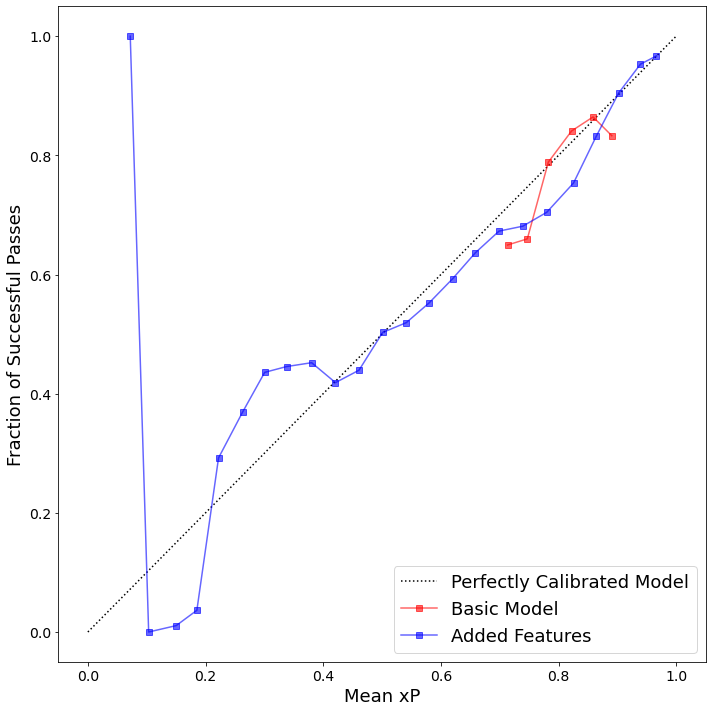

In [22]:
plot_calibration_curve(df_passes_test, show_advanced=0, save_output=1)

### Calibration Curve - Advanced Models: Logit Vs Probit

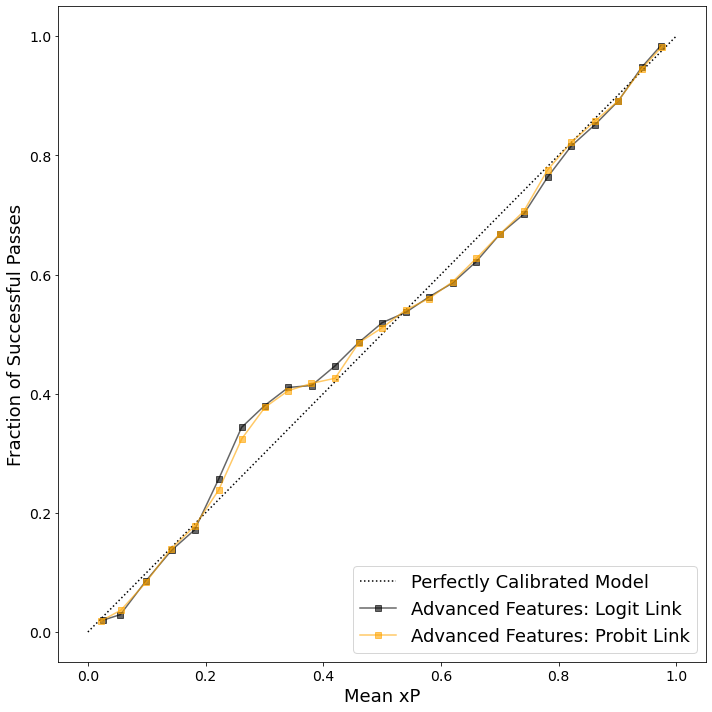

In [23]:
plot_calibration_curve(df_passes_test, show_advanced=1, save_output=1)

---

&nbsp;

&nbsp;

&nbsp;

# 7) Applying Logistic Regression Classifier and Calculating Model Fit Metrics

In [24]:
calculate_model_metrics(df_passes_test, 'xP')

Brier Score: 0.10642146614710772

Precision Score: 0.9005178325572422

Recall Score: 0.9105388462288744

F1 Score: 0.9055006150495346

AUC Score: 0.7092062601966227

AccuracyScore: 0.8422029087937452


---

# 8) Applying advanced model to `df_passes` (**test + training** data) and **summarising best forwards at "risky" passes in England**

In [25]:
leagues = ['England'] #['England','Spain','Italy','Germany','France']
positions = ['FWD']
xPthreshold = 0.5
minMatches = 10
minPasses = 50

In [26]:
# applying advanced model to predict xP
df_passes['xP'] = pass_model_advanced_probit.predict(df_passes)
# calculating "overxP"
df_passes['overxP'] = df_passes['successFlag'] - df_passes['xP']

## get average distance and average y distance metrics, too

df_overall_pcSuccess = df_passes.loc[df_passes['source'].isin(leagues)]\
                                .groupby(['playerId','shortName'])\
                                .agg({'successFlag':np.sum,'id':'nunique'})\
                                .rename(columns={'successFlag':'overallSuccessful','id':'overallAttempted'})

df_overall_pcSuccess['overallPcCompleted'] = np.round(100*df_overall_pcSuccess['overallSuccessful'] / df_overall_pcSuccess['overallAttempted'], 1)

# producing summary, adding in formations data to calculate the excess xP per 90 minutes
df_summary_passer = df_passes.loc[(df_passes['roleCode'].isin(positions))\
                           & (df_passes['source'].isin(leagues))\
                           & (df_passes['xP'] < xPthreshold)]\
        .merge(df_formations, on=['matchId','teamId','playerId'], how='inner')\
        .groupby(['matchId','playerId','roleCode','minutesPlayed','shortName'])\
        .agg({'overxP':np.sum,'id':'nunique','successFlag':np.sum,'vec_x':np.sum})\
        .reset_index()\
        .rename(columns={'id':'totAttemptedPerMatch','successFlag':'totSuccessfulPerMatch'})\
        .groupby(['playerId','shortName','roleCode'])\
        .agg({'overxP':np.sum,'totAttemptedPerMatch':np.sum,'totSuccessfulPerMatch':np.sum,'minutesPlayed':np.sum,'matchId':'nunique','vec_x':np.sum})\
        .rename(columns={'totAttemptedPerMatch':'totAttempted','totSuccessfulPerMatch':'totSuccessful','matchId':'totMatches'})\
        .sort_values('overxP', ascending=False)\
        .reset_index()

# getting the overall fraction of completed passes
df_summary_passer['pcCompleted'] = np.round(100*df_summary_passer['totSuccessful'] / df_summary_passer['totAttempted'], 1)
# getting a normalised metric per 90 minutes of play
df_summary_passer['overxPper90mins'] = np.round(90*(df_summary_passer['overxP'] / df_summary_passer['minutesPlayed']), 1)
# getting a normalised metric per 100 attempts
df_summary_passer['overxPper100attempts'] = np.round(100*(df_summary_passer['overxP'] / df_summary_passer['totAttempted']), 1)
# explicitly making mins played an integer
df_summary_passer['minutesPlayed'] = df_summary_passer.minutesPlayed.apply(lambda x: int(x))
# rounding overxP score
df_summary_passer['overxP'] = np.round(df_summary_passer['overxP'], 1)

# joining difficult pass table to overall pc completed table
df_summary_passer = df_summary_passer.merge(df_overall_pcSuccess, on=['playerId','shortName'], how='inner')
df_summary_passer['pcTrickyBall'] = np.round(100*df_summary_passer['totAttempted'] / df_summary_passer['overallAttempted'], 1)

# filtering using minimum criteria
df_summary_passer = df_summary_passer.loc[(df_summary_passer['totMatches'] >= minMatches) & (df_summary_passer['totAttempted'] >= minPasses)]

df_summary_passer = df_summary_passer[['playerId','shortName','roleCode','overxP','overxPper90mins','overxPper100attempts','totSuccessful','totAttempted','pcCompleted','minutesPlayed','totMatches','pcTrickyBall','overallPcCompleted','vec_x']]

df_summary_passer.sort_values('overxPper100attempts', ascending=False).head(40)


,playerId,shortName,roleCode,overxP,overxPper90mins,overxPper100attempts,totSuccessful,totAttempted,pcCompleted,minutesPlayed,totMatches,pcTrickyBall,overallPcCompleted,vec_x
0,25707,E. Hazard,FWD,17.1,0.6,13.9,59,123,48.0,2432,34,8.8,85.0,748.65
2,7944,W. Rooney,FWD,9.0,0.4,8.4,50,108,46.3,2238,30,9.0,80.0,2674.35
6,8325,S. Agüero,FWD,4.2,0.2,8.1,21,52,40.4,1739,22,8.5,84.7,22.05
4,25747,S. Mané,FWD,6.8,0.3,6.5,40,104,38.5,2184,27,11.0,82.4,-30.45
5,9637,J. King,FWD,6.3,0.3,6.1,40,104,38.5,2160,28,16.2,75.3,489.30
1,3361,A. Sánchez,FWD,14.3,0.5,6.0,99,236,41.9,2553,31,15.7,74.0,2404.50
12,7879,T. Walcott,FWD,3.1,0.2,4.5,26,69,37.7,1188,17,19.4,74.4,359.10
18,25413,A. Lacazette,FWD,2.1,0.1,3.6,21,57,36.8,1832,25,8.7,79.1,130.20
20,9123,A. Barnes,FWD,1.9,0.1,3.4,21,55,38.2,1779,26,13.4,67.9,-106.05
11,134513,A. Martial,FWD,3.2,0.2,3.2,34,99,34.3,1551,27,12.9,80.8,-371.70


## Latex Table of Results

In [27]:
print(df_summary_passer.sort_values('overxPper100attempts', ascending=False).head(10).to_latex(index_names=False, index=None\
                                                                                              ,columns=['shortName','overxPper100attempts'\
                                                                                                        ,'totAttempted','pcTrickyBall']))

\begin{tabular}{lrrr}
\toprule
    shortName &  overxPper100attempts &  totAttempted &  pcTrickyBall \\
\midrule
    E. Hazard &                  13.9 &           123 &           8.8 \\
    W. Rooney &                   8.4 &           108 &           9.0 \\
    S. Agüero &                   8.1 &            52 &           8.5 \\
      S. Mané &                   6.5 &           104 &          11.0 \\
      J. King &                   6.1 &           104 &          16.2 \\
   A. Sánchez &                   6.0 &           236 &          15.7 \\
   T. Walcott &                   4.5 &            69 &          19.4 \\
 A. Lacazette &                   3.6 &            57 &           8.7 \\
    A. Barnes &                   3.4 &            55 &          13.4 \\
   A. Martial &                   3.2 &            99 &          12.9 \\
\bottomrule
\end{tabular}



## Hazard distribution visualisation

In [28]:
df_hazard = df_passes.loc[(df_passes['playerId'] == 25707) & (df_passes['source'] == 'England')\
                          & (df_passes['xP'] < 0.5)]

df_hazard = df_hazard.merge(df_players.rename(columns={'playerId':'passRecipientPlayerId'}), on='passRecipientPlayerId', how='inner', suffixes=(['_hazard','_receiver']))

hazard_main_receivers = ['Álvaro Morata','Willian','Pedro','Fàbregas','V. Moses','O. Giroud']

df_hazard_main_receivers = df_hazard.loc[df_hazard['shortName_receiver'].isin(hazard_main_receivers)][['source','matchId','eventSec','subEventName','previousSubEventName','shortName_hazard','shortName_receiver','xP','overxP','startPassM_x','startPassM_y','endPassM_x','endPassM_y']]

## Plotting Hazard Passes by Receiver

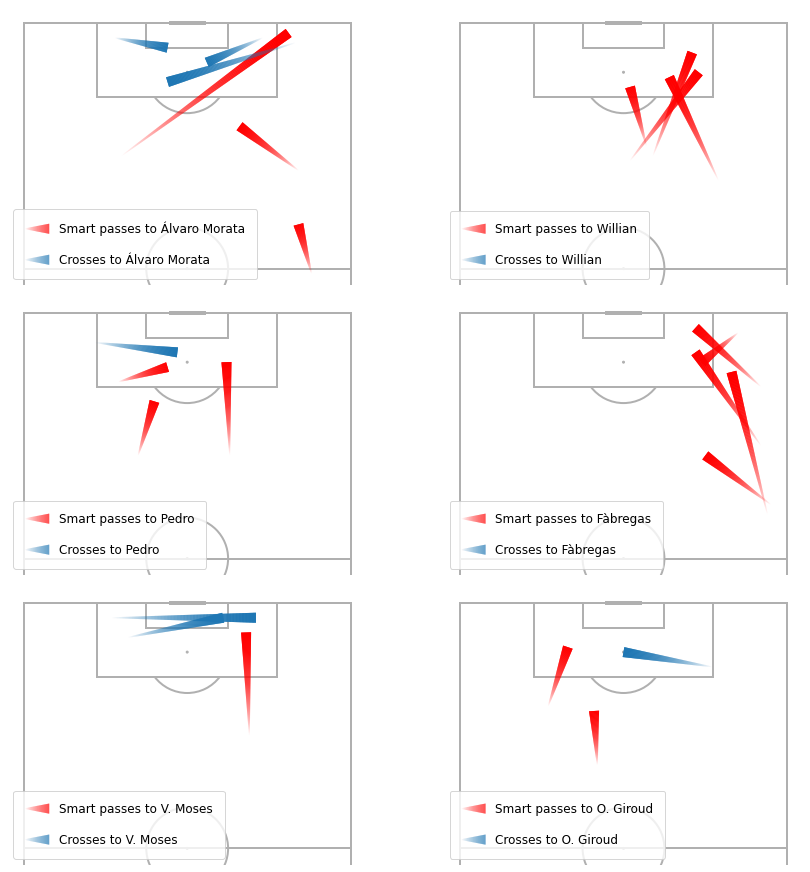

In [29]:
pitch = Pitch(layout=(3, 2), tight_layout=False, constrained_layout=True, view='half', orientation='vertical', figsize=(12,12))

fig, axs = pitch.draw()

for ax, receiver in zip(axs.flat, hazard_main_receivers):
    
    df_receiver = df_hazard_main_receivers.loc[df_hazard_main_receivers['shortName_receiver'] == receiver]
    
    # smart passes
    pitch.lines(df_receiver.loc[df_receiver['subEventName'] == 'Smart pass'].startPassM_x*120/105, df_receiver.loc[df_receiver['subEventName'] == 'Smart pass'].startPassM_y*80/68,\
                df_receiver.loc[df_receiver['subEventName'] == 'Smart pass'].endPassM_x*120/105, df_receiver.loc[df_receiver['subEventName'] == 'Smart pass'].endPassM_y*80/68,
                lw=10, transparent=True, comet=True,
                label=f'Smart passes to {receiver}', color='red', ax=ax, alpha_start=0.01, alpha_end=1)
    
    # crosses
    pitch.lines(df_receiver.loc[df_receiver['subEventName'] == 'Cross'].startPassM_x*120/105, df_receiver.loc[df_receiver['subEventName'] == 'Cross'].startPassM_y*80/68,\
                df_receiver.loc[df_receiver['subEventName'] == 'Cross'].endPassM_x*120/105, df_receiver.loc[df_receiver['subEventName'] == 'Cross'].endPassM_y*80/68,
                lw=10, transparent=True, comet=True,
                label=f'Crosses to {receiver}', ax=ax, alpha_start=0.01, alpha_end=1)

    leg = ax.legend(borderpad=1, markerscale=1.5, labelspacing=1.5, loc='lower left', fontsize=12)

fig.savefig('Hazard.pdf', format='pdf',dpi=300,pad_inches=0,bbox_inches='tight', transparent=True)

## Looking at Receivers

In [30]:
# producing summary, adding in formations data to calculate the excess xP per 90 minutes

df_passes_receiver = df_passes.copy()
df_passes_receiver = df_passes_receiver.drop(columns=['playerId','shortName','roleCode'])
df_passes_receiver = df_passes_receiver.rename(columns={'passRecipientPlayerId':'playerId'})
df_passes_receiver = df_passes_receiver.loc[pd.isna(df_passes_receiver['playerId']) == False]

df_passes_receiver = df_passes_receiver.merge(df_players, on=['playerId'], how='inner')

df_summary_receiver = df_passes_receiver.loc[(df_passes_receiver['roleCode'].isin(positions))\
                           & (df_passes_receiver['source'].isin(leagues))\
                           & (df_passes_receiver['xP'] < xPthreshold)]\
        .merge(df_formations, on=['matchId','teamId','playerId'], how='inner')\
        .groupby(['matchId','playerId','minutesPlayed','shortName'])\
        .agg({'overxP':np.sum,'id':'nunique','successFlag':np.sum})\
        .reset_index()\
        .rename(columns={'id':'totAttemptedPerMatch','successFlag':'totCompletedPerMatch'})\
        .groupby(['playerId','shortName'])\
        .agg({'overxP':np.sum,'totAttemptedPerMatch':np.sum,'totCompletedPerMatch':np.sum,'minutesPlayed':np.sum,'matchId':'nunique'})\
        .rename(columns={'totAttemptedPerMatch':'totAttempted','totCompletedPerMatch':'totCompleted','matchId':'totMatches'})\
        .sort_values('overxP', ascending=False)\
        .reset_index()

df_summary_receiver['fracCompleted'] = df_summary_receiver['totCompleted'] / df_summary_receiver['totAttempted']
df_summary_receiver['overxPper90received'] = 90*(df_summary_receiver['overxP'] / df_summary_receiver['minutesPlayed'])
df_summary_receiver = df_summary_receiver.loc[df_summary_receiver['totMatches'] >= 10]

df_summary_receiver.sort_values('overxPper90received', ascending=False).head()

,playerId,shortName,overxP,totAttempted,totCompleted,minutesPlayed,totMatches,fracCompleted,overxPper90received
26,26010.0,O. Giroud,23.778349,37,37,728.0,17,1.0,2.939631
15,11669.0,C. Wilson,28.063730,44,44,1238.0,18,1.0,2.040174
22,10663.0,A. Gray,24.590565,40,40,1120.0,18,1.0,1.976028
9,8384.0,S. Long,31.249384,50,50,1453.0,22,1.0,1.935612
5,9123.0,A. Barnes,35.533073,57,57,1665.0,21,1.0,1.920707
